# Data from 2020

In [13]:
df_covid = pd.read_csv('data/dpc-covid19-ita-andamento-nazionale.csv', parse_dates = ['data'])
df_covid = df_covid[df_covid['data'] < '2020-12-31']
df_covid['data'] = pd.to_datetime(df_covid['data']).dt.date
df_covid = df_covid.drop(columns = ['casi_da_sospetto_diagnostico', 'casi_da_screening', 'tamponi', 'casi_testati', 'note', 'ingressi_terapia_intensiva', 
                                   'note_test', 'note_casi', 'totale_positivi_test_molecolare', 'totale_positivi_test_antigenico_rapido', 'tamponi_test_molecolare',
                                   'tamponi_test_antigenico_rapido', 'ricoverati_con_sintomi', 'terapia_intensiva', 'stato', 'isolamento_domiciliare',
                                   'totale_ospedalizzati', 'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti', 'deceduti', 'totale_casi'])

xdata = df_covid['data']
start_day = xdata[0]
end_day = xdata[len(xdata)-1]
df_covid.index = df_covid['data']
df_covid = df_covid.drop(columns=['data'])

In [14]:
I = df_covid['totale_positivi']
#R = df_covid['recovered_death']
#N = 9981554

### $R_t$ comparison

In [15]:
# R_t ISS using covidstat
Rt_iss = pd.read_csv('data/iss/iss_rt_italia.csv',  parse_dates = ['data'])
Rt_iss = Rt_iss.dropna()
Rt_iss = Rt_iss.set_index('data')
Rt_iss = Rt_iss[start_day:end_day]
Rt_iss = Rt_iss.drop(columns=['rt_positivi_err68perc', 'rt_sintomatici', 'rt_sintomatici_err68perc'])

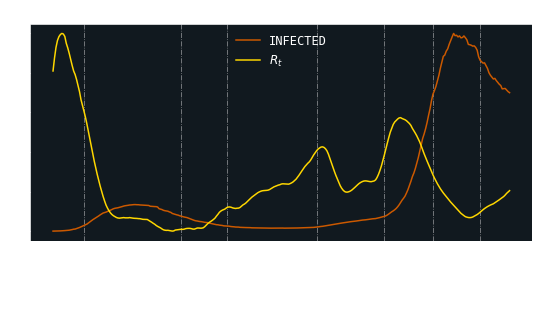

In [16]:
fig, ax = plt.subplots(1,1, figsize=(9, 4), facecolor='#11191F')
fig.patch.set_alpha(0.0)
ax.set_facecolor(('#11191F'))
ax.tick_params(color='#FFFFFF', labelcolor='#FFFFFF')
for spine in ax.spines.values():
        spine.set_edgecolor('#FFFFFF')

ax.set_title('INFECTED AND $R_t$', fontdict={'family': 'monospace', 'fontsize':12, 'fontweight':3}, color='#FFFFFF')

plt.plot(normalized(df_covid['totale_positivi']), '#CC5900', markersize=5)
plt.plot(normalized(Rt_iss['rt_positivi']), 'gold', markersize=5)
#plt.title('Infected in Italy 2020, fit and Rt', color = '#FFFFFF')
ax.legend(['INFECTED', '$R_t$'], framealpha = 0, labelcolor = '#FFFFFF', prop = {'size':12,'family':'monospace'})
plt.xticks([xdata[21], xdata[87],xdata[118],xdata[179],xdata[225],xdata[258],xdata[290]],
           labels=[str(xdata[21]) +'\n'+ 'Start first lockdown',
            str(xdata[87]) +'\n'+ 'End first lockdown',
            str(xdata[118]) +'\n'+ 'Middle summer',
            str(xdata[179]) +'\n'+ 'End summer',
            str(xdata[225]) +'\n'+ 'Second lockdown',
            str(xdata[258]) +'\n'+ 'More restrictions',
            str(xdata[290]) +'\n'+ 'Winter'], rotation = 35,
    fontsize=8, fontname='monospace')
plt.yticks(fontsize=10)
ax.grid(axis='x', color = '#FFFFFF', linestyle='-.', alpha = 0.5)
plt.savefig("fig/infected_rt.png", bbox_inches = 'tight', dpi=300)
plt.show()

### $R_t$ and mobility

In [6]:
df = pd.read_csv('data/Region_Mobility_Report_CSVs/2020_IT_Region_Mobility_Report.csv')
df = df[~df['sub_region_1'].isnull()]
region_names = pd.unique(df['sub_region_1'])
region_names_italian = ['abruzzo', 'aosta','piemonte','basilicata','calabria','campania','emilia_romagna','friuli_venezia_giulia',
'lazio','liguria','lombardia','marche','molise','piemonte','sardegna','sicilia','trentino_alto_adige','toscana','umbria','veneto']
# categories name
names = ['retail_and_recreation_percent_change_from_baseline',
        'grocery_and_pharmacy_percent_change_from_baseline',
        'parks_percent_change_from_baseline',
        'transit_stations_percent_change_from_baseline',
        'workplaces_percent_change_from_baseline',
        'residential_percent_change_from_baseline']

In [11]:
# Dataframe dove storare i risultati
region_report = pd.DataFrame(region_names, columns = ['region_name'])
cut = False
for name in names:
    values = []
    shifts = []
    for r in range(len(region_names)):
        Rt_iss = pd.read_csv('data/iss/iss_rt_'+region_names_italian[r]+'.csv')
        Rt_iss = Rt_iss.drop(columns=['rt_positivi_err68perc', 'rt_sintomatici','rt_sintomatici_err68perc'])
        Rt_iss = Rt_iss.rename(columns={"data": "date"})
        
        df = pd.read_csv('data/Region_Mobility_Report_CSVs/2020_IT_Region_Mobility_Report.csv')
        df = df[df['sub_region_1'] == region_names[r]]
        df = df[df['sub_region_2'].isnull()]
        df = df.drop(columns=['sub_region_1', 'country_region_code', 'country_region','sub_region_2','metro_area', 'iso_3166_2_code', 'census_fips_code', 'place_id'])
        
        df_region = pd.merge(Rt_iss, df)
        df_region = df_region.dropna()
        df_region['date'] = pd.to_datetime(df_region['date'])
        df_region.index = df_region['date']
        df_region = df_region.drop(columns = ['date'])
        df_region[name] = normalized(df_region[name])
        df_region['rt_positivi'] = normalized(df_region['rt_positivi'])
        
        data_1 = df_region[name]
        data_2 = df_region['rt_positivi']
        rolling_median = data_1.rolling(window=7).median()
        rolling_std = data_1.rolling(window=7).std()
        to_drop = []
        for i in range(len(data_1)):
            if (data_1[i] > rolling_median[i] + 1*rolling_std[i]) | (data_1[i] < rolling_median[i] - 1*rolling_std[i]):
                to_drop.append(i)
        df_region = df_region.drop(df_region.index[to_drop])
        
        if cut:
            df_region_cutted = df_region[(df_region.index >= str(xdata[0])) & (df_region.index <= str(xdata[len(xdata)-1]))]
            data_1 = df_region_cutted[name]
        else:
            data_1 = df_region[name]
        correlations = []
        for i in range(-30, 31):
            df_region_shift = df_region['rt_positivi'].shift(i)
            if cut:
                data_2 = df_region_shift[(df_region_shift.index >= str(xdata[0])) & (df_region_shift.index <= str(xdata[len(xdata)-1]))]
            else:
                data_2 = df_region_shift
            data_2 = data_2[~np.isnan(data_2)]
            if i < 0:
                data_1_cut = data_1[:len(data_2)]
            else:
                data_1_cut = data_1[len(data_1) - len(data_2):]
            correlations.append(stats.spearmanr(data_1_cut, data_2)[0])

        mi = np.min(correlations)
        ma = np.max(correlations)
        if np.abs(mi) > ma:
            values.append(np.min(correlations))
            shifts.append(np.arange(-30,31)[np.argmin(correlations)])
        else:
            values.append(np.max(correlations))
            shifts.append(np.arange(-30,31)[np.argmax(correlations)])
    region_report[name] = values
    region_report[name[:5] + 'shifts'] = shifts

In [ ]:
region_report = region_report.rename(columns={"region_name": "NOME_REG"})

In [ ]:
italy = gpd.read_file('map/reg2011_g.shp')
new_regions = pd.read_csv('map/reg2011_g.csv')
italy['NOME_REG'] = new_regions['NOME_REG']
merge = italy.merge(region_report, on='NOME_REG', how='right')

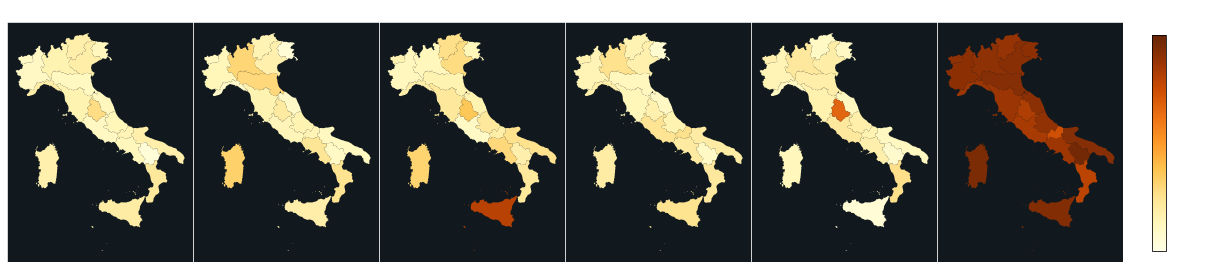

In [ ]:
vmin=-1
vmax=1
fig, ax = plt.subplots(1,6, figsize=(20, 5), facecolor='#11191F')
fig.subplots_adjust(hspace=0.0, wspace=0.0)
fig.patch.set_alpha(0.0)

ax[0].tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=False)
ax[1].tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=False)
ax[2].tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=False)
ax[3].tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=False)
ax[4].tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=False)
ax[5].tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=False)

ax[0].set_facecolor(('#11191F'))
ax[1].set_facecolor(('#11191F'))
ax[2].set_facecolor(('#11191F'))
ax[3].set_facecolor(('#11191F'))
ax[4].set_facecolor(('#11191F'))
ax[5].set_facecolor(('#11191F'))

for spine in ax[0].spines.values():
        spine.set_edgecolor('#FFFFFF')
for spine in ax[1].spines.values():
        spine.set_edgecolor('#FFFFFF')
for spine in ax[2].spines.values():
        spine.set_edgecolor('#FFFFFF')
for spine in ax[3].spines.values():
        spine.set_edgecolor('#FFFFFF')
for spine in ax[4].spines.values():
        spine.set_edgecolor('#FFFFFF')
for spine in ax[5].spines.values():
        spine.set_edgecolor('#FFFFFF')

ax[0].set_title('RETAIL AND RECREATION', fontdict={'family': 'monospace', 'fontsize':12, 'fontweight':3}, color='#FFFFFF')
merge.plot(ax=ax[0], column='retail_and_recreation_percent_change_from_baseline', cmap='YlOrBr', label='ciao', vmin=vmin, vmax=vmax)

ax[1].set_title('GROCERY AND PHARMACY', fontdict={'family': 'monospace', 'fontsize':12, 'fontweight':3}, color='#FFFFFF')
merge.plot(ax=ax[1], column='grocery_and_pharmacy_percent_change_from_baseline', cmap='YlOrBr', label='ciao', vmin=vmin, vmax=vmax)

ax[2].set_title('PARKS', fontdict={'family': 'monospace', 'fontsize':12, 'fontweight':3}, color='#FFFFFF')
merge.plot(ax=ax[2], column='parks_percent_change_from_baseline', cmap='YlOrBr', label='ciao', vmin=vmin, vmax=vmax)

ax[3].set_title('TRANSIT STATIONS', fontdict={'family': 'monospace', 'fontsize':12, 'fontweight':3}, color='#FFFFFF')
merge.plot(ax=ax[3], column='transit_stations_percent_change_from_baseline', cmap='YlOrBr', label='ciao', vmin=vmin, vmax=vmax)

ax[4].set_title('WORKPLACES', fontdict={'family': 'monospace', 'fontsize':12, 'fontweight':3}, color='#FFFFFF')
merge.plot(ax=ax[4], column='workplaces_percent_change_from_baseline', cmap='YlOrBr', label='ciao', vmin=vmin, vmax=vmax)

ax[5].set_title('RESIDENTIAL', fontdict={'family': 'monospace', 'fontsize':12, 'fontweight':3}, color='#FFFFFF')
merge.plot(ax=ax[5], column='residential_percent_change_from_baseline', cmap='YlOrBr', label='ciao', vmin=vmin, vmax=vmax)

cax = fig.add_axes([0.92,0.2,0.01,0.6])
sm = plt.cm.ScalarMappable(cmap='YlOrBr', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cax.tick_params(colors='#FFFFFF')

plt.savefig("fig/mobility_rt.png", bbox_inches = 'tight', dpi=300)
plt.show()

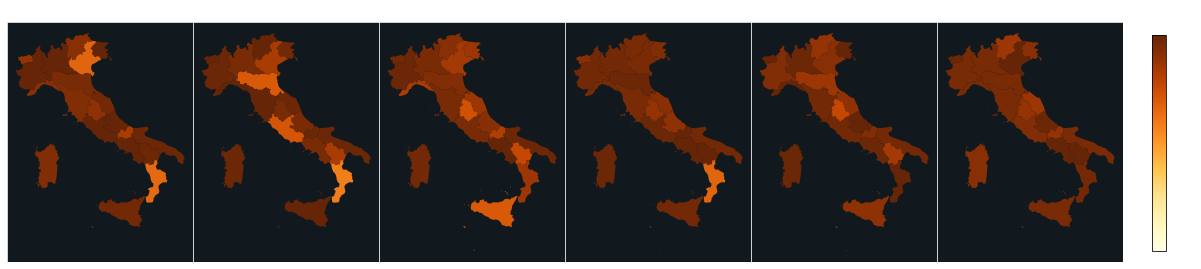

In [ ]:
vmin=-30
vmax=30
fig, ax = plt.subplots(1,6, figsize=(20, 5), facecolor='#11191F')
fig.subplots_adjust(hspace=0.0, wspace=0.0)
fig.patch.set_alpha(0.0)

ax[0].tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=False)
ax[1].tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=False)
ax[2].tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=False)
ax[3].tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=False)
ax[4].tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=False)
ax[5].tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=False)

ax[0].set_facecolor(('#11191F'))
ax[1].set_facecolor(('#11191F'))
ax[2].set_facecolor(('#11191F'))
ax[3].set_facecolor(('#11191F'))
ax[4].set_facecolor(('#11191F'))
ax[5].set_facecolor(('#11191F'))

for spine in ax[0].spines.values():
        spine.set_edgecolor('#FFFFFF')
for spine in ax[1].spines.values():
        spine.set_edgecolor('#FFFFFF')
for spine in ax[2].spines.values():
        spine.set_edgecolor('#FFFFFF')
for spine in ax[3].spines.values():
        spine.set_edgecolor('#FFFFFF')
for spine in ax[4].spines.values():
        spine.set_edgecolor('#FFFFFF')
for spine in ax[5].spines.values():
        spine.set_edgecolor('#FFFFFF')

ax[0].set_title('RETAIL AND RECREATION', fontdict={'family': 'monospace', 'fontsize':12, 'fontweight':3}, color='#FFFFFF')
merge.plot(ax=ax[0], column='retaishifts', cmap='YlOrBr', label='ciao', vmin=vmin, vmax=vmax)

ax[1].set_title('GROCERY AND PHARMACY', fontdict={'family': 'monospace', 'fontsize':12, 'fontweight':3}, color='#FFFFFF')
merge.plot(ax=ax[1], column='groceshifts', cmap='YlOrBr', label='ciao', vmin=vmin, vmax=vmax)

ax[2].set_title('PARKS', fontdict={'family': 'monospace', 'fontsize':12, 'fontweight':3}, color='#FFFFFF')
merge.plot(ax=ax[2], column='parksshifts', cmap='YlOrBr', label='ciao', vmin=vmin, vmax=vmax)

ax[3].set_title('TRANSIT STATIONS', fontdict={'family': 'monospace', 'fontsize':12, 'fontweight':3}, color='#FFFFFF')
merge.plot(ax=ax[3], column='transshifts', cmap='YlOrBr', label='ciao', vmin=vmin, vmax=vmax)

ax[4].set_title('WORKPLACES', fontdict={'family': 'monospace', 'fontsize':12, 'fontweight':3}, color='#FFFFFF')
merge.plot(ax=ax[4], column='workpshifts', cmap='YlOrBr', label='ciao', vmin=vmin, vmax=vmax)

ax[5].set_title('RESIDENTIAL', fontdict={'family': 'monospace', 'fontsize':12, 'fontweight':3}, color='#FFFFFF')
merge.plot(ax=ax[5], column='residshifts', cmap='YlOrBr', label='ciao', vmin=vmin, vmax=vmax)

cax = fig.add_axes([0.92,0.2,0.01,0.6])
sm = plt.cm.ScalarMappable(cmap='YlOrBr', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cax.tick_params(colors='#FFFFFF')

plt.savefig("fig/mobility_rt_shift.png", bbox_inches = 'tight', dpi=300)
plt.show()

### $I$ and mobility

In [528]:
# Dataframe dove storare i risultati
cut = False
region_report = pd.DataFrame(region_names, columns = ['region_name'])
for name in names:
    values = []
    shifts = []
    for r in range(len(region_names)):
        
        df_covid = pd.read_csv('data/dpc-covid19-ita-regioni.csv', parse_dates = ['data'])
        df_covid.loc[df_covid['denominazione_regione'] == "Valle d'Aosta", 'denominazione_regione'] = 'Aosta'
        df_covid.loc[df_covid['denominazione_regione'] == "Emilia-Romagna", 'denominazione_regione'] = 'Emilia_romagna'
        df_covid.loc[df_covid['denominazione_regione'] == "Friuli Venezia Giulia", 'denominazione_regione'] = 'Friuli_venezia_giulia'
        df_covid.loc[df_covid['denominazione_regione'] == "P.A. Bolzano", 'denominazione_regione'] = 'Trentino_alto_adige'
        df_covid.loc[df_covid['denominazione_regione'] == "P.A. Trento", 'denominazione_regione'] = 'Trentino_alto_adige'
        df_covid = df_covid[df_covid['denominazione_regione'] == region_names_italian[r][0].upper()+region_names_italian[r][1:]]
        df_covid['data'] = pd.to_datetime(df_covid['data']).dt.strftime('%Y-%m-%d')
        df_covid = df_covid.drop(columns = ['casi_da_sospetto_diagnostico', 'casi_da_screening', 'tamponi', 'casi_testati', 'note', 'ingressi_terapia_intensiva', 
                                           'note_test', 'note_casi', 'totale_positivi_test_molecolare', 'totale_positivi_test_antigenico_rapido', 'tamponi_test_molecolare',
                                           'tamponi_test_antigenico_rapido', 'ricoverati_con_sintomi', 'terapia_intensiva', 'stato', 'isolamento_domiciliare',
                                           'totale_ospedalizzati', 'codice_regione', 'denominazione_regione', 'lat', 'long', 'codice_nuts_1' , 'codice_nuts_2',
                                           'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti', 'deceduti', 'totale_casi'])
        df_covid = df_covid.rename(columns={"data": "date"})
        df = pd.read_csv('data/Region_Mobility_Report_CSVs/2020_IT_Region_Mobility_Report.csv')
        df = df[df['sub_region_1'] == region_names[r]]
        df = df[df['sub_region_2'].isnull()]
        df = df.drop(columns=['sub_region_1', 'country_region_code', 'country_region','sub_region_2','metro_area', 'iso_3166_2_code', 'census_fips_code', 'place_id'])
        
        df_region = pd.merge(df_covid, df)
        df_region = df_region.dropna()
        df_region['date'] = pd.to_datetime(df_region['date'])
        df_region.index = df_region['date']
        df_region = df_region.drop(columns = ['date'])
        df_region[name] = normalized(df_region[name])
        df_region['totale_positivi'] = normalized(df_region['totale_positivi'])

        data_1 = df_region[name]
        data_2 = df_region['totale_positivi']
        rolling_median = data_1.rolling(window=7).median()
        rolling_std = data_1.rolling(window=7).std()
        to_drop = []
        for i in range(len(data_1)):
            if (data_1[i] > rolling_median[i] + 1*rolling_std[i]) | (data_1[i] < rolling_median[i] - 1*rolling_std[i]):
                to_drop.append(i)
        df_region = df_region.drop(df_region.index[to_drop])
        
        if cut:
            df_region_cutted = df_region[(df_region.index >= str(xdata[118])) & (df_region.index <= str(xdata[290]))]
            data_1 = df_region_cutted[name]
        else:
            data_1 = df_region[name]
            
        correlations = []
        for i in range(-15, 16):
            df_region_shift = df_region['totale_positivi'].shift(i)
            if cut:
                data_2 = df_region_shift[(df_region_shift.index >= str(xdata[118])) & (df_region_shift.index <= str(xdata[290]))]
            else:
                data_2 = df_region_shift
            data_2 = data_2[~np.isnan(data_2)]
            if i < 0:
                data_1_cut = data_1[:len(data_2)]
            else:
                data_1_cut = data_1[len(data_1) - len(data_2):]
            correlations.append(stats.spearmanr(data_1_cut, data_2)[0])

        mi = np.min(correlations)
        ma = np.max(correlations)
        if np.abs(mi) > ma:
            values.append(np.min(correlations))
            shifts.append(np.arange(-15,16)[np.argmin(correlations)])
        else:
            values.append(np.max(correlations))
            shifts.append(np.arange(-15,16)[np.argmax(correlations)])
    region_report[name] = values
    region_report[name[:5] + 'shifts'] = shifts

In [529]:
region_report = region_report.rename(columns={"region_name": "NOME_REG"})

In [530]:
italy = gpd.read_file('map/reg2011_g.shp')
new_regions = pd.read_csv('map/reg2011_g.csv')
italy['NOME_REG'] = new_regions['NOME_REG']
merge = italy.merge(region_report, on='NOME_REG', how='right')

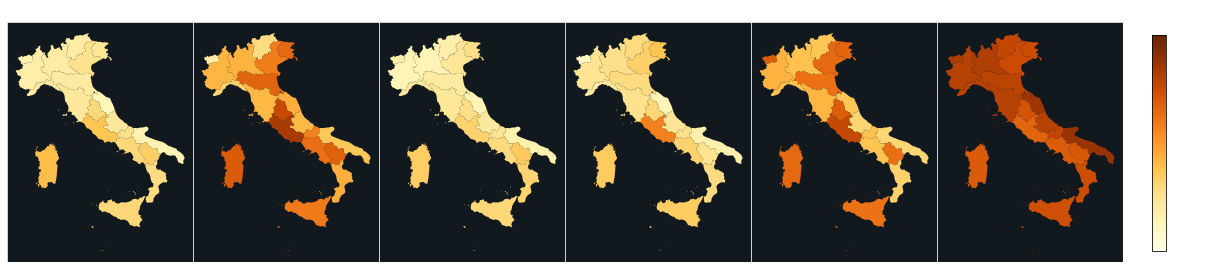

In [533]:
vmin=-1
vmax=1
fig, ax = plt.subplots(1,6, figsize=(20, 5), facecolor='#11191F')
fig.subplots_adjust(hspace=0.0, wspace=0.0)
fig.patch.set_alpha(0.0)

ax[0].tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=False)
ax[1].tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=False)
ax[2].tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=False)
ax[3].tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=False)
ax[4].tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=False)
ax[5].tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=False)

ax[0].set_facecolor(('#11191F'))
ax[1].set_facecolor(('#11191F'))
ax[2].set_facecolor(('#11191F'))
ax[3].set_facecolor(('#11191F'))
ax[4].set_facecolor(('#11191F'))
ax[5].set_facecolor(('#11191F'))

for spine in ax[0].spines.values():
        spine.set_edgecolor('#FFFFFF')
for spine in ax[1].spines.values():
        spine.set_edgecolor('#FFFFFF')
for spine in ax[2].spines.values():
        spine.set_edgecolor('#FFFFFF')
for spine in ax[3].spines.values():
        spine.set_edgecolor('#FFFFFF')
for spine in ax[4].spines.values():
        spine.set_edgecolor('#FFFFFF')
for spine in ax[5].spines.values():
        spine.set_edgecolor('#FFFFFF')

ax[0].set_title('RETAIL AND RECREATION', fontdict={'family': 'monospace', 'fontsize':12, 'fontweight':3}, color='#FFFFFF')
merge.plot(ax=ax[0], column='retail_and_recreation_percent_change_from_baseline', cmap='YlOrBr', label='ciao', vmin=vmin, vmax=vmax)

ax[1].set_title('GROCERY AND PHARMACY', fontdict={'family': 'monospace', 'fontsize':12, 'fontweight':3}, color='#FFFFFF')
merge.plot(ax=ax[1], column='grocery_and_pharmacy_percent_change_from_baseline', cmap='YlOrBr', label='ciao', vmin=vmin, vmax=vmax)

ax[2].set_title('PARKS', fontdict={'family': 'monospace', 'fontsize':12, 'fontweight':3}, color='#FFFFFF')
merge.plot(ax=ax[2], column='parks_percent_change_from_baseline', cmap='YlOrBr', label='ciao', vmin=vmin, vmax=vmax)

ax[3].set_title('TRANSIT STATIONS', fontdict={'family': 'monospace', 'fontsize':12, 'fontweight':3}, color='#FFFFFF')
merge.plot(ax=ax[3], column='transit_stations_percent_change_from_baseline', cmap='YlOrBr', label='ciao', vmin=vmin, vmax=vmax)

ax[4].set_title('WORKPLACES', fontdict={'family': 'monospace', 'fontsize':12, 'fontweight':3}, color='#FFFFFF')
merge.plot(ax=ax[4], column='workplaces_percent_change_from_baseline', cmap='YlOrBr', label='ciao', vmin=vmin, vmax=vmax)

ax[5].set_title('RESIDENTIAL', fontdict={'family': 'monospace', 'fontsize':12, 'fontweight':3}, color='#FFFFFF')
merge.plot(ax=ax[5], column='residential_percent_change_from_baseline', cmap='YlOrBr', label='ciao', vmin=vmin, vmax=vmax)

cax = fig.add_axes([0.92,0.2,0.01,0.6])
sm = plt.cm.ScalarMappable(cmap='YlOrBr', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cax.tick_params(colors='#FFFFFF')

plt.savefig("fig/mobility_i.png", bbox_inches = 'tight', dpi=300)
plt.show()

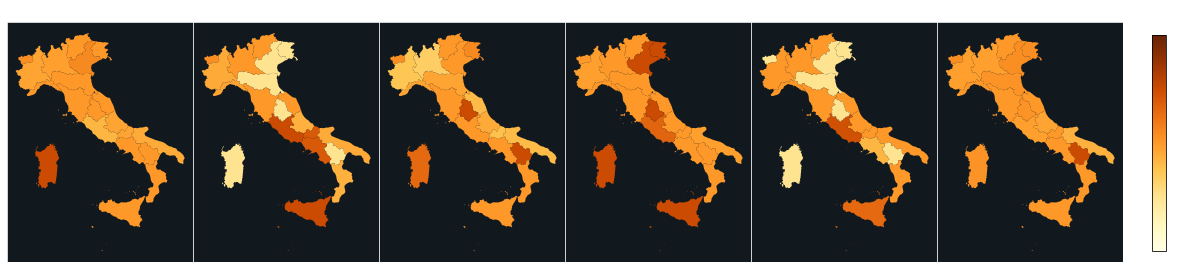

In [534]:
vmin=-30
vmax=30
fig, ax = plt.subplots(1,6, figsize=(20, 5), facecolor='#11191F')
fig.subplots_adjust(hspace=0.0, wspace=0.0)
fig.patch.set_alpha(0.0)

ax[0].tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=False)
ax[1].tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=False)
ax[2].tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=False)
ax[3].tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=False)
ax[4].tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=False)
ax[5].tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=False)

ax[0].set_facecolor(('#11191F'))
ax[1].set_facecolor(('#11191F'))
ax[2].set_facecolor(('#11191F'))
ax[3].set_facecolor(('#11191F'))
ax[4].set_facecolor(('#11191F'))
ax[5].set_facecolor(('#11191F'))

for spine in ax[0].spines.values():
        spine.set_edgecolor('#FFFFFF')
for spine in ax[1].spines.values():
        spine.set_edgecolor('#FFFFFF')
for spine in ax[2].spines.values():
        spine.set_edgecolor('#FFFFFF')
for spine in ax[3].spines.values():
        spine.set_edgecolor('#FFFFFF')
for spine in ax[4].spines.values():
        spine.set_edgecolor('#FFFFFF')
for spine in ax[5].spines.values():
        spine.set_edgecolor('#FFFFFF')

ax[0].set_title('RETAIL AND RECREATION', fontdict={'family': 'monospace', 'fontsize':12, 'fontweight':3}, color='#FFFFFF')
merge.plot(ax=ax[0], column='retaishifts', cmap='YlOrBr', label='ciao', vmin=vmin, vmax=vmax)

ax[1].set_title('GROCERY AND PHARMACY', fontdict={'family': 'monospace', 'fontsize':12, 'fontweight':3}, color='#FFFFFF')
merge.plot(ax=ax[1], column='groceshifts', cmap='YlOrBr', label='ciao', vmin=vmin, vmax=vmax)

ax[2].set_title('PARKS', fontdict={'family': 'monospace', 'fontsize':12, 'fontweight':3}, color='#FFFFFF')
merge.plot(ax=ax[2], column='parksshifts', cmap='YlOrBr', label='ciao', vmin=vmin, vmax=vmax)

ax[3].set_title('TRANSIT STATIONS', fontdict={'family': 'monospace', 'fontsize':12, 'fontweight':3}, color='#FFFFFF')
merge.plot(ax=ax[3], column='transshifts', cmap='YlOrBr', label='ciao', vmin=vmin, vmax=vmax)

ax[4].set_title('WORKPLACES', fontdict={'family': 'monospace', 'fontsize':12, 'fontweight':3}, color='#FFFFFF')
merge.plot(ax=ax[4], column='workpshifts', cmap='YlOrBr', label='ciao', vmin=vmin, vmax=vmax)

ax[5].set_title('RESIDENTIAL', fontdict={'family': 'monospace', 'fontsize':12, 'fontweight':3}, color='#FFFFFF')
merge.plot(ax=ax[5], column='residshifts', cmap='YlOrBr', label='ciao', vmin=vmin, vmax=vmax)

cax = fig.add_axes([0.92,0.2,0.01,0.6])
sm = plt.cm.ScalarMappable(cmap='YlOrBr', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cax.tick_params(colors='#FFFFFF')

plt.savefig("fig/mobility_i_shift.png", bbox_inches = 'tight', dpi=300)
plt.show()

### $<k>$ and $R_t$ 

In [535]:
average_network_degree = pd.read_csv('data/italy_mobility/average_network_degree_2020_01_18_2020_06_26.csv')
regioni = pd.read_csv('data/italy_mobility/province-italiane.csv', delimiter=';')
regioni = regioni.drop(columns=['Provincia'])
prova = pd.merge(average_network_degree, regioni, how='inner', left_on = 'SIGLA', right_on = 'Sigla')
prova = prova.drop(columns=['Sigla', 'COD_PROV', 'SIGLA', 'Unnamed: 0', 'NAME_PROV'])
prova = prova.groupby('Regione', as_index=False, sort=False)[prova.columns[:-47]].mean().T
new_header = np.array(prova.iloc[0]).astype(str)
new_header[3] = 'Aosta'
new_header[9] = 'Emilia_romagna'
new_header[10] = 'Trentino_alto_adige'
new_header[17] = 'Friuli_venezia_giulia'
prova = prova[1:]
prova.columns = new_header #set the header row as the df header
#prova

In [536]:
df = pd.read_csv('data/Region_Mobility_Report_CSVs/2020_IT_Region_Mobility_Report.csv')
df = df[~df['sub_region_1'].isnull()]
region_names = pd.unique(df['sub_region_1'])
region_names_italian = ['abruzzo', 'aosta','piemonte','basilicata','calabria','campania','emilia_romagna','friuli_venezia_giulia',
'lazio','liguria','lombardia','marche','molise','piemonte','sardegna','sicilia','trentino_alto_adige','toscana','umbria','veneto']
# Dataframe dove storare i risultati
region_report = pd.DataFrame(region_names, columns = ['region_name'])
xdata_covid = xdata
names = ['retail_and_recreation_percent_change_from_baseline',
        'grocery_and_pharmacy_percent_change_from_baseline',
        'parks_percent_change_from_baseline',
        'transit_stations_percent_change_from_baseline',
        'workplaces_percent_change_from_baseline',
        'residential_percent_change_from_baseline']

In [560]:
cut = False
values = []
shifts = []
for r in range(len(region_names)):
    df_k = prova[region_names_italian[r][0].upper()+region_names_italian[r][1:]].rename('k')
    
    Rt_iss = pd.read_csv('data/iss/iss_rt_'+region_names_italian[r]+'.csv')
    Rt_iss = Rt_iss.drop(columns=['rt_positivi_err68perc', 'rt_sintomatici','rt_sintomatici_err68perc'])
    Rt_iss = Rt_iss.rename(columns={"data": "date"})
    
    df_region = pd.merge(df_k, Rt_iss, left_index = True, right_on = 'date')
    df_region = df_region.dropna()
    df_region['date'] = pd.to_datetime(df_region['date'])
    df_region = df_region[df_region['date']<'2020-05-04']
    df_region.index = df_region['date']
    df_region = df_region.drop(columns = ['date'])
    df_region['k'] = df_region['k'].astype(np.float64)
    df_region['k'] = normalized(df_region['k'])
    df_region['rt_positivi'] = normalized(df_region['rt_positivi'])
    data_1 = df_region['k']
    data_2 = df_region['rt_positivi']
    
    rolling_median = data_1.rolling(window=3).median()
    rolling_std = data_1.rolling(window=3).std()
    to_drop = []
    for i in range(len(data_1)):
        if (data_1[i] > rolling_median[i] + 1*rolling_std[i]) | (data_1[i] < rolling_median[i] - 1*rolling_std[i]):
            to_drop.append(i)
    df_region = df_region.drop(df_region.index[to_drop])
    
    if cut:
        df_region_cutted = df_region[(df_region.index >= str(xdata[80])) & (df_region.index <= str(xdata[260]))]
        data_1 = df_region_cutted['k']
    else:
        data_1 = df_region['k']

    correlations = []
    for i in range(-15, 16):
        df_region_shift = df_region['rt_positivi'].shift(i)
        if cut:
            data_2 = df_region_shift[(df_region_shift.index >= str(xdata[225])) & (df_region_shift.index <= str(xdata[260]))]
        else:
            data_2 = df_region_shift
        data_2 = data_2[~np.isnan(data_2)]
        if i < 0:
            data_1_cut = data_1[:len(data_2)]
        else:
            data_1_cut = data_1[len(data_1) - len(data_2):]
        correlations.append(stats.spearmanr(data_1_cut, data_2)[0])

    mi = np.min(correlations)
    ma = np.max(correlations)
    if np.abs(mi) > ma:
        values.append(np.min(correlations))
        shifts.append(np.arange(-15,16)[np.argmin(correlations)])
    else:
        values.append(np.max(correlations))
        shifts.append(np.arange(-15,16)[np.argmax(correlations)])
        
region_report['correlations'] = values
region_report['correlations shifts'] = shifts

In [561]:
region_report = region_report.rename(columns={"region_name": "NOME_REG"})

In [562]:
italy = gpd.read_file('map/reg2011_g.shp')
new_regions = pd.read_csv('map/reg2011_g.csv')
italy['NOME_REG'] = new_regions['NOME_REG']
merge = italy.merge(region_report, on='NOME_REG', how='right')

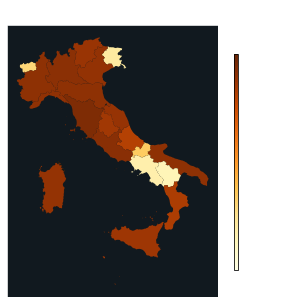

In [559]:
vmin=-1
vmax=1
fig, ax = plt.subplots(1, figsize=(5, 5), facecolor='#11191F')
fig.subplots_adjust(hspace=0.0, wspace=0.0)
fig.patch.set_alpha(0.0)

ax.tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=False)

ax.set_facecolor(('#11191F'))

for spine in ax.spines.values():
        spine.set_edgecolor('#FFFFFF')

ax.set_title('$<k>$ and $R_t$', fontdict={'family': 'monospace', 'fontsize':12, 'fontweight':3}, color='#FFFFFF')
merge.plot(ax=ax, column='correlations', cmap='YlOrBr', label='ciao', vmin=vmin, vmax=vmax)

cax = fig.add_axes([0.85,0.2,0.01,0.6])
sm = plt.cm.ScalarMappable(cmap='YlOrBr', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cax.tick_params(colors='#FFFFFF')

plt.savefig("fig/k_rt.png", bbox_inches = 'tight', dpi=300)
plt.show()

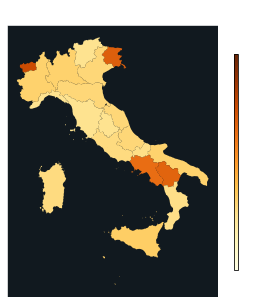

In [563]:
vmin=-30
vmax=30
fig, ax = plt.subplots(1, figsize=(5, 5), facecolor='#11191F')
fig.subplots_adjust(hspace=0.0, wspace=0.0)
fig.patch.set_alpha(0.0)

ax.tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=False)

ax.set_facecolor(('#11191F'))

for spine in ax.spines.values():
        spine.set_edgecolor('#FFFFFF')

ax.set_title('$<k>$ and $R_t$', fontdict={'family': 'monospace', 'fontsize':12, 'fontweight':3}, color='#FFFFFF')
merge.plot(ax=ax, column='correlations shifts', cmap='YlOrBr', label='ciao', vmin=vmin, vmax=vmax)

cax = fig.add_axes([0.85,0.2,0.01,0.6])
sm = plt.cm.ScalarMappable(cmap='YlOrBr', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cax.tick_params(colors='#FFFFFF')

plt.savefig("fig/k_rt_shifts.png", bbox_inches = 'tight', dpi=300)
plt.show()

### Radius and $R_t$

In [564]:
df = pd.read_csv('data/Region_Mobility_Report_CSVs/2020_IT_Region_Mobility_Report.csv')
df = df[~df['sub_region_1'].isnull()]
region_names = pd.unique(df['sub_region_1'])
region_names_italian = ['abruzzo', 'aosta','piemonte','basilicata','calabria','campania','emilia_romagna','friuli_venezia_giulia',
'lazio','liguria','lombardia','marche','molise','piemonte','sardegna','sicilia','trentino_alto_adige','toscana','umbria','veneto']
# Dataframe dove storare i risultati
region_report = pd.DataFrame(region_names, columns = ['region_name'])
#xdata_covid = xdata
names = ['retail_and_recreation_percent_change_from_baseline',
        'grocery_and_pharmacy_percent_change_from_baseline',
        'parks_percent_change_from_baseline',
        'transit_stations_percent_change_from_baseline',
        'workplaces_percent_change_from_baseline',
        'residential_percent_change_from_baseline']

In [577]:
values = []
shifts = []
for r in range(len(region_names)):
    median_q1_q3 = pd.read_csv('data/italy_mobility/median_q1_q3_rog_2020_01_18_2020_06_26.csv')
    regioni = pd.read_csv('data/italy_mobility/province-italiane.csv', delimiter=';')
    regioni = regioni.drop(columns=['Provincia'])

    radius = pd.merge(median_q1_q3, regioni, how='inner', left_on = 'SIGLA', right_on = 'Sigla').drop(columns=['Sigla', 'COD_PROV', 'DEN_PCM', 'SIGLA'])
    radius.loc[radius['Regione'] == "Valle d'Aosta", 'Regione'] = 'Aosta'
    radius.loc[radius['Regione'] == "Emilia Romagna", 'Regione'] = 'Emilia_romagna'
    radius.loc[radius['Regione'] == "Trentino Alto Adige", 'Regione'] = 'Trentino_alto_adige'
    radius.loc[radius['Regione'] == "Friuli Venezia Giulia", 'Regione'] = 'Friuli_venezia_giulia'
    radius = radius.groupby('Regione', as_index=False, sort=False)[radius.columns[:-47]].mean()
    radius = radius[radius['Regione'] == region_names_italian[r][0].upper()+region_names_italian[r][1:]].T
    new_header = np.array(radius.iloc[0]).astype(str)
    new_header = np.insert(new_header, 0,'date')
    radius = radius[1:]
    radius = radius.reset_index(level=0)
    radius.columns = new_header
    radius = radius[:17]
    radius_dup = radius.loc[radius.index.repeat(7)]
    
    Rt_iss = pd.read_csv('data/iss/iss_rt_'+region_names_italian[r]+'.csv')
    Rt_iss = Rt_iss.drop(columns=['rt_positivi_err68perc', 'rt_sintomatici','rt_sintomatici_err68perc'])
    Rt_iss = Rt_iss.rename(columns={"data": "date"})
    Rt_iss['date'] = pd.to_datetime(Rt_iss['date'])
    Rt_iss = Rt_iss.dropna().reset_index()
    Rt_iss = Rt_iss.drop(columns = ['index'])
    
    date_between = []
    start_date = datetime.datetime.strptime('2020-01-18','%Y-%m-%d').date()
    end_date = datetime.datetime.strptime('2020-05-15','%Y-%m-%d').date()
    delta = end_date - start_date   # returns timedelta

    for i in range(delta.days + 1):
        day = start_date + datetime.timedelta(days=i)
        date_between.append(day)
    end_date = date_between[-1]
    start_date = pd.to_datetime(Rt_iss['date'][0]).date()
    radius_dup['date_between'] = date_between
    radius_dup = radius_dup[radius_dup['date_between'] >= start_date]
    idx_0 = radius_dup.index[0]
    idx_1 = radius_dup.index[-1]
    
    radius = radius[idx_0:idx_1]
    # fatto, ora raggruppiamo gli rt per settimana
    Rt_iss = Rt_iss[Rt_iss['date'].dt.date < end_date ]
    Rt_iss = Rt_iss.groupby(pd.Grouper(key='date', axis=0, freq='7D'))['rt_positivi'].mean()
    Rt_iss = Rt_iss[:len(radius)]
    radius[region_names_italian[r][0].upper()+region_names_italian[r][1:]] = radius[region_names_italian[r][0].upper()+region_names_italian[r][1:]].astype(np.float64)
    radius = radius.reset_index()
    
    Rt_iss = np.array(Rt_iss)
    ydata = radius[region_names_italian[r][0].upper()+region_names_italian[r][1:]]
    
    ydata = normalized(ydata)
    Rt_iss = normalized(Rt_iss)
    
    # Togliere outlier da mobility
    rolling_median = ydata.rolling(window=1).median()
    rolling_std = ydata.rolling(window=1).std()
    diff = ydata - rolling_median

    to_drop = []
    for i in range(len(ydata)):
        if (ydata[i] > rolling_median[i] + 1*rolling_std[i]) | (ydata[i] < rolling_median[i] - 1*rolling_std[i]):
            to_drop.append(i)

    ydata_new = np.array(ydata)
    rolling_median_new = np.array(rolling_median)
    xdata_new = np.array(xdata)
    Rt_iss_new = np.array(Rt_iss)

    ydata_new = np.delete(ydata_new, to_drop)
    rolling_median_new = np.delete(rolling_median_new, to_drop)
    xdata_new = np.delete(xdata_new, to_drop)
    Rt_iss_new = np.delete(Rt_iss, to_drop)
    
    # i_sh = shift(Rt_iss_new, -2)
    # i_sh = i_sh[~np.isnan(i_sh)]
    # plt.plot(ydata)
    # plt.plot(i_sh)
    # plt.show()
    
    correlations = []
    # Tengo fisso la I e shifto la mobilità, da -20 a +20 giorni
    # questi sono per i -20 a 0
    for i in range(-1, 0, 1):
        mob_sh = shift(ydata_new, i)
        mob_sh = mob_sh[~np.isnan(mob_sh)]
        correlations.append(stats.spearmanr(mob_sh, Rt_iss_new[:len(mob_sh)])[0])
    # questo per 0, 20
    for i in range(0, 4, 1):
        i_sh = shift(Rt_iss_new, -i)
        i_sh = i_sh[~np.isnan(i_sh)]
        correlations.append(stats.spearmanr(i_sh, ydata_new[:len(i_sh)])[0])
    mi = np.min(correlations)
    ma = np.max(correlations)

    if np.abs(mi) > ma:
        values.append(np.min(correlations))
        shifts.append(np.arange(-1,4)[np.argmin(correlations)])
    else:
        values.append(np.max(correlations))
        shifts.append(np.arange(-1,4)[np.argmax(correlations)])
        
region_report['correlations'] = values
region_report['correlations shifts'] = shifts

In [578]:
region_report = region_report.rename(columns={"region_name": "NOME_REG"})

In [579]:
region_report['correlations shifts'] = -region_report['correlations shifts']

In [580]:
italy = gpd.read_file('map/reg2011_g.shp')
new_regions = pd.read_csv('map/reg2011_g.csv')
italy['NOME_REG'] = new_regions['NOME_REG']
merge = italy.merge(region_report, on='NOME_REG', how='right')

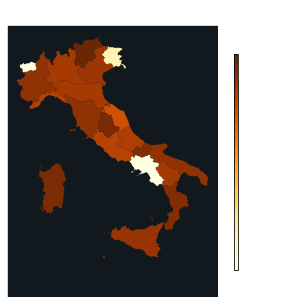

In [584]:
vmin=-1
vmax=1
fig, ax = plt.subplots(1, figsize=(5, 5), facecolor='#11191F')
fig.subplots_adjust(hspace=0.0, wspace=0.0)
fig.patch.set_alpha(0.0)

ax.tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=False)

ax.set_facecolor(('#11191F'))


for spine in ax.spines.values():
        spine.set_edgecolor('#FFFFFF')

ax.set_title('$<k>$ and $R_t$', fontdict={'family': 'monospace', 'fontsize':12, 'fontweight':3}, color='#FFFFFF')
merge.plot(ax=ax, column='correlations', cmap='YlOrBr', label='ciao', vmin=vmin, vmax=vmax)

cax = fig.add_axes([0.85,0.2,0.01,0.6])
sm = plt.cm.ScalarMappable(cmap='YlOrBr', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cax.tick_params(colors='#FFFFFF')

plt.savefig("fig/radius_rt.png", bbox_inches = 'tight', dpi=300)
plt.show()

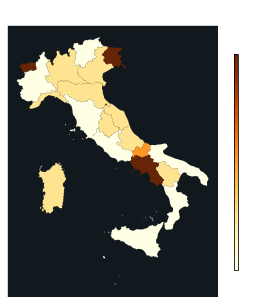

In [585]:
vmin=-3
vmax=1
fig, ax = plt.subplots(1, figsize=(5, 5), facecolor='#11191F')
fig.subplots_adjust(hspace=0.0, wspace=0.0)
fig.patch.set_alpha(0.0)

ax.tick_params(top=False,bottom=False,left=False,right=False,labelleft=False,labelbottom=False)

ax.set_facecolor(('#11191F'))

for spine in ax.spines.values():
        spine.set_edgecolor('#FFFFFF')

ax.set_title('$<k>$ and $R_t$', fontdict={'family': 'monospace', 'fontsize':12, 'fontweight':3}, color='#FFFFFF')
merge.plot(ax=ax, column='correlations shifts', cmap='YlOrBr', label='ciao', vmin=vmin, vmax=vmax)

cax = fig.add_axes([0.85,0.2,0.01,0.6])
sm = plt.cm.ScalarMappable(cmap='YlOrBr', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cax)
cax.tick_params(colors='#FFFFFF')

plt.savefig("fig/radius_rt_shifts.png", bbox_inches = 'tight', dpi=300)
plt.show()